# Description

> Use the Flowers dataset and a pretrained ResNet 18 to demonstrate why initial layers are frozen during the first few epochs of transfer learning. Does your model do better or worse when you freeze the initial layers for the first few epochs?

## flowers

* main http://www.robots.ox.ac.uk/~vgg/data/flowers/102/
* tutorial None
* download 	https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz
* SOTA https://paperswithcode.com/sota/fine-grained-image-classification-on-oxford

## Resnet 18

* main https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.resnet18
* tutorial https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
!pip freeze | grep -v fastai | wc -l | grep -w "0" && pip install fastai

In [3]:
from fastai.vision.all import *

In [4]:
path=untar_data('https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz')

In [5]:
path.ls()

(#7) [Path('/home/tyoc213/.fastai/data/oxford-102-flowers/test.txt'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/val'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/models'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/train'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/train.txt'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/valid.txt')]

In [6]:
p0,p2,p3 = path.ls()[0], path.ls()[2], path.ls()[3]
!echo "test" && tail $p0 && cat $p0 | wc -l
!echo "train" && tail $p2 && cat $p2 | wc -l
!echo "valid" && tail $p3 && cat $p3 | wc -l
(path/'jpg').ls()

test
jpg/image_00985.jpg 45
jpg/image_06412.jpg 8
jpg/image_07145.jpg 44
jpg/image_00638.jpg 88
jpg/image_07558.jpg 94
jpg/image_08168.jpg 61
jpg/image_07487.jpg 94
jpg/image_04432.jpg 89
jpg/image_02532.jpg 75
jpg/image_00178.jpg 76
6149
train
tail: error reading '/home/tyoc213/.fastai/data/oxford-102-flowers/jpg': Is a directory
valid
tail: error reading '/home/tyoc213/.fastai/data/oxford-102-flowers/models': Is a directory


(#8189) [Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_04376.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_01488.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_01097.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_07466.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_06858.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_05681.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_07165.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_05913.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_02539.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_07056.jpg')...]

In [7]:
df_train = pd.read_csv(path/'train.txt', header=0,sep=" ", names=['img', 'label'])
df_train['is_valid'] = False
df_valid = pd.read_csv(path/'valid.txt', header=0,sep=" ", names=['img', 'label'])
df_valid['is_valid'] = True
df = pd.concat([df_train, df_valid])
df.head(), df.tail()

(                   img  label  is_valid
 0  jpg/image_06092.jpg     13     False
 1  jpg/image_02400.jpg     42     False
 2  jpg/image_02852.jpg     55     False
 3  jpg/image_07710.jpg     96     False
 4  jpg/image_07191.jpg      5     False,
                       img  label  is_valid
 1014  jpg/image_08182.jpg     61      True
 1015  jpg/image_07029.jpg     38      True
 1016  jpg/image_05956.jpg     67      True
 1017  jpg/image_06051.jpg     13      True
 1018  jpg/image_07724.jpg     96      True)

In [8]:
dls = ImageDataLoaders.from_df(df, path, valid_col='is_valid',
                               bs=64,
                               item_tfms=Resize(320)
                              )

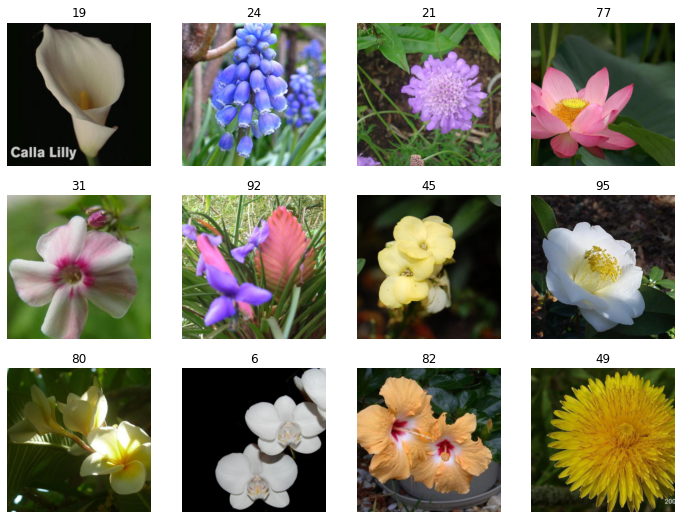

In [9]:
dls.show_batch(max_n=12)

## used vars and methods

In [12]:
MODELO=resnet18
MIN_EPOCHS=3

@patch_to(Learner)
def print_trainable_count(self):
    linfo = [(o[1], o[2]) for o in layer_info(learn, learn.dls.one_batch()[0]) if o is not None and o[3] is not None and o[1] is not '']
    total,trainable=0,0
    for c, t in linfo:
        total += c
        if t: trainable += c
    print(f'Trainable {trainable:,}, not trainable {total-trainable:,}. Total params: {total:,}')

<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-12-77e8f8d48bf0>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  linfo = [(o[1], o[2]) for o in layer_info(learn, learn.dls.one_batch()[0]) if o is not None and o[3] is not None and o[1] is not '']


## use the preferred learning rate

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.010964781977236271)

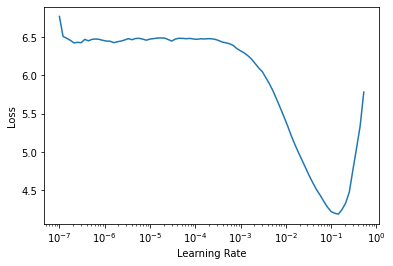

In [13]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.lr_find()

## first unfreeze and train

In [ ]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.unfreeze()
learn.print_trainable_count()
learn.fit(MIN_EPOCHS*2,lr=0.01)

Trainable 11,756,096, not trainable 0. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,6.185959,11856.591797,0.990186,0.009814,00:10


In [14]:
learn??

## normal call

In [12]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.print_trainable_count()
learn.fit(MIN_EPOCHS*2,lr=0.01)

Trainable 589,184, not trainable 11,166,912. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.873168,4.137469,0.710500,0.289500,00:07
1,2.270839,1.591137,0.399411,0.600589,00:07
2,1.485604,1.053990,0.268891,0.731109,00:08
3,1.044750,0.862981,0.226693,0.773307,00:08
4,0.768266,1.052933,0.250245,0.749755,00:07
5,0.590197,0.800770,0.202159,0.797841,00:07


## freeze first, then unfreeze and freeze again

In [13]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.freeze_to(-1)
learn.print_trainable_count()
learn.fit(MIN_EPOCHS*2,lr=0.01)

Trainable 589,184, not trainable 11,166,912. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.752481,4.604897,0.727184,0.272816,00:07
1,2.180768,1.515095,0.363101,0.636899,00:07
2,1.428915,1.076359,0.265947,0.734053,00:07
3,1.001166,0.798617,0.211973,0.788027,00:07
4,0.747544,0.838258,0.216879,0.783121,00:07
5,0.579925,0.852672,0.216879,0.783121,00:07


In [14]:
learn.freeze_to(-2)
learn.print_trainable_count()
learn.fit(MIN_EPOCHS,lr=0.01)

Trainable 11,074,944, not trainable 681,152. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,6.334148,422.826447,0.990186,0.009814,00:07
1,5.389382,15.629828,0.956820,0.043180,00:07
2,4.590200,4.233865,0.838077,0.161923,00:07


In [16]:
learn.freeze_to(-3)
learn.print_trainable_count()
learn.fit(MIN_EPOCHS,lr=0.01)

Trainable 11,756,096, not trainable 0. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,6.200259,2637.012939,0.990186,0.009814,00:08
1,6.036861,181.334030,0.986261,0.013739,00:07
2,5.782084,6.909907,0.963690,0.036310,00:07


## groups of the model

When fastai downloads resnet it happens a head which is trainable which is `learn.model[1]`, so we focus on `learn.model[1]`

In [20]:
learn.model[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [38]:
type(learn.model), type(learn.model[0]), type(learn.model[0][0]), type(learn.model[0][7]), type(learn.model[0][7][0])

(torch.nn.modules.container.Sequential,
 torch.nn.modules.container.Sequential,
 torch.nn.modules.conv.Conv2d,
 torch.nn.modules.container.Sequential,
 torchvision.models.resnet.BasicBlock)

In [39]:
isinstance(learn.model, nn.Module), isinstance(learn.model[0], nn.Module), isinstance(learn.model[0][7][0], nn.Module)

(True, True, True)

In [20]:
def set_grad(module, req_grad=False):
    for p in module.parameters():
        p.requires_grad = req_grad

def count_params(module):
    train, not_train = 0,0
    for p in module.parameters():
        if p.requires_grad:
            train += p.numel() #1
        else:
            not_train += p.numel() #1
    return train, not_train


In [21]:
module = learn.model[0][7]
len(params(module)), '=', len(params(module[0])), '+',len(params(module[1]))

(15, '=', 9, '+', 6)

In [43]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.fit(MIN_EPOCHS, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.797355,3.888509,0.658489,0.341511,00:06
1,2.181237,1.898499,0.426889,0.573111,00:06
2,1.424278,1.070681,0.283611,0.716389,00:06


In [27]:
print('     Starting')
print('module', count_params(module))
learn.print_trainable_count()
print('     All True count')
set_grad(module, True)
print('module', count_params(module))
learn.print_trainable_count()

     Starting
module (8393728, 0)


Trainable 8,713,702, not trainable 2,778,304. Total params: 11,492,006
     All True count
module (8393728, 0)


Trainable 8,713,702, not trainable 2,778,304. Total params: 11,492,006


In [46]:
learn.fit(MIN_EPOCHS, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,5.175173,81.274361,0.979392,0.020608,00:06
1,4.201419,5.872329,0.801766,0.198234,00:06
2,3.450940,3.527155,0.667321,0.332679,00:06


In [51]:
module = learn.model[0][0]
len(params(module)), '=', len(params(module))

(1, '=', 1)

In [52]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.fit(MIN_EPOCHS, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.752222,3.161222,0.617272,0.382728,00:06
1,2.200372,1.441661,0.355250,0.644750,00:06
2,1.454770,1.035136,0.277723,0.722277,00:06


In [53]:
print('     Starting')
print(count_params(module))
learn.print_trainable_count()
print('     All True count')
set_grad(module, True)
print(count_params(module))
learn.print_trainable_count()

     Starting
(1, 0)


Trainable 589,184, not trainable 11,166,912. Total params: 11,756,096
     All True count
(1, 0)


Trainable 589,184, not trainable 11,166,912. Total params: 11,756,096


In [54]:
learn.fit(MIN_EPOCHS, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.390502,1.137486,0.276742,0.723258,00:06
1,0.306902,0.927665,0.239450,0.760550,00:06
2,0.272834,0.779958,0.209028,0.790972,00:06


In [55]:
learn.fit(MIN_EPOCHS, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.162663,0.769130,0.196271,0.803729,00:06
1,0.169467,1.004515,0.234544,0.765456,00:06
2,0.161173,0.944544,0.230618,0.769382,00:06


In [13]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.fit(MIN_EPOCHS, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.616459,4.107266,0.700687,0.299313,00:11
1,2.154174,1.353213,0.339549,0.660451,00:10
2,1.438369,1.048644,0.284593,0.715407,00:10


In [ ]:
set_grad(module, True)

In [58]:
learn.fit(4, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.361498,0.857587,0.199215,0.800785,00:06
1,0.285121,0.817325,0.194308,0.805692,00:06
2,0.262234,1.023641,0.235525,0.764475,00:06
3,0.236817,0.859693,0.196271,0.803729,00:06


In [59]:
learn.freeze_to(-1)
learn.print_trainable_count()
learn.fit(MIN_EPOCHS, lr=0.01)

Trainable 589,184, not trainable 11,166,912. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.463880,1.688219,0.352306,0.647694,00:06
1,0.556625,1.783953,0.350343,0.649657,00:06
2,0.486484,1.230257,0.241413,0.758587,00:06


In [60]:
learn.fit(MIN_EPOCHS*3, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.275009,0.970085,0.201178,0.798822,00:06
1,0.260896,1.111422,0.240432,0.759568,00:06
2,0.236401,1.565528,0.272816,0.727184,00:06
3,0.225192,0.905659,0.186457,0.813543,00:06
4,0.257428,1.245333,0.246320,0.753680,00:06
5,0.274041,1.491646,0.267910,0.732090,00:06
6,0.272034,1.006605,0.193327,0.806673,00:06
7,0.285982,1.425780,0.244357,0.755643,00:06
8,0.264988,1.112279,0.205103,0.794897,00:06


In [61]:
learn.fit(MIN_EPOCHS*10, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.228841,1.205071,0.217861,0.782139,00:06
1,0.231447,1.758239,0.273798,0.726202,00:06
2,0.246255,1.233360,0.219823,0.780177,00:06
3,0.233931,1.376822,0.256133,0.743867,00:06
4,0.199979,1.370563,0.240432,0.759568,00:06
5,0.181063,1.284255,0.226693,0.773307,00:06
6,0.174841,1.330204,0.215898,0.784102,00:06
7,0.164545,1.185934,0.198234,0.801766,00:06
8,0.168630,1.332948,0.219823,0.780177,00:06
9,0.172340,1.299900,0.210991,0.789009,00:06


In [69]:
learn.model[0][7][0].conv1.weight.shape, learn.model[0][7][1].conv1.weight.shape

(torch.Size([512, 256, 3, 3]), torch.Size([512, 512, 3, 3]))

In [70]:
512*256*3*3 + 512*512*3*3

3538944

In [74]:
589184 - 8977792

-8388608

In [75]:
8388608-3538944

4849664

## creating a different head

In [21]:
create_head??

In [11]:
# layers = [AdaptiveConcatPool2d(), Flatten(), nn.Linear(512,102)]
layers = [Flatten(), nn.Linear(512,102)]
head2 = create_head(512, 102, concat_pool=False, lin_first=True)
head = nn.Sequential(*layers)

learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy], custom_head=head2)
learn.fit(7, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.315655,5.131880,0.838077,0.161923,00:08
1,2.928736,1.744410,0.418057,0.581943,00:08
2,2.115249,1.012568,0.256133,0.743867,00:08
3,1.594445,0.797885,0.212954,0.787046,00:08
4,1.250388,0.840436,0.216879,0.783121,00:08
5,1.005572,0.702170,0.188420,0.811580,00:08
6,0.815228,0.797426,0.202159,0.797841,00:08


## remplace only last layer

In [11]:
original_r18 = resnet18(true)

######### NOTE: requires_grad = False for all parameters
for param in original_r18.parameters():
    param.requires_grad = False

######### NOTE: so only the last Linear layer will be updated on backpropagation
num_ftrs = original_r18.fc.in_features
original_r18.fc = nn.Linear(num_ftrs, 102)

original_r18 = original_r18.to(torch.device('cuda'))
learn = Learner(dls, original_r18, metrics=[error_rate, accuracy])
learn.print_trainable_count()
learn.fit(MIN_EPOCHS*3, lr=0.01)

Trainable 52,326, not trainable 11,176,512. Total params: 11,228,838


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,5.875055,4.088998,0.742885,0.257115,00:07
1,3.814313,1.804624,0.409225,0.590775,00:08
2,2.495201,1.180559,0.300294,0.699706,00:08
3,1.727758,1.007867,0.257115,0.742885,00:08
4,1.234356,0.963886,0.249264,0.750736,00:08
5,0.909693,0.835019,0.219823,0.780177,00:07
6,0.677886,0.680842,0.183513,0.816487,00:07
7,0.508490,0.663087,0.178606,0.821394,00:07
8,0.382028,0.605796,0.154073,0.845927,00:07


# pytorch example adapted data

In pytorch the transfer learning they use `hymenoptera_data.zip` so lets preprocess the data to match `train/labels/images`and `val/labels/images` we can chech that with:

In [13]:
newp = untar_data('https://download.pytorch.org/tutorial/hymenoptera_data.zip');(newp).ls()

(#2) [Path('/home/tyoc213/.fastai/data/hymenoptera_data/val'),Path('/home/tyoc213/.fastai/data/hymenoptera_data/train')]

In [55]:
import os
import shutil

# create all label directories for train and val
for l in dls.vocab:
    os.makedirs(path/f'train/{l}', exist_ok=True)
    os.makedirs(path/f'val/{l}', exist_ok=True)

# copy files to target location
for idx, i in enumerate(df.iloc):
    imgp = path/i.img
    name = imgp.name.replace('jpg/', '')
    final = path/f'val/{i.label}/{name}' if i.is_valid else path/f'train/{i.label}/{name}'
    shutil.copyfile(imgp, final)
#     if idx % 100 == 0: print('copied', idx)

In [56]:
newp = path

In [67]:
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

###########################################################

model_conv = torchvision.models.resnet18(pretrained=True)

######### NOTE: requires_grad = False for all parameters
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
######### NOTE: so only the last Linear layer will be updated on backpropagation
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 102) ######### NOTE: adjust to 102 the otput, if not: RuntimeError: CUDA error: device-side assert triggered

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

###########################################################

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 102) ######### NOTE: adjust to 102 the otput, if not: RuntimeError: CUDA error: device-side assert triggered

###########################################################

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    device = torch.device("cpu") #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model





data_dir = newp
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


#model_ft = train_model(model_ft, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 4.7232 Acc: 0.0157
val Loss: 3.9513 Acc: 0.1501

Epoch 1/24
----------
train Loss: 4.0755 Acc: 0.1119
val Loss: 3.0720 Acc: 0.3739

Epoch 2/24
----------
train Loss: 3.5183 Acc: 0.2326
val Loss: 2.5488 Acc: 0.4877

Epoch 3/24
----------
train Loss: 3.0851 Acc: 0.3680
val Loss: 2.0349 Acc: 0.5937

Epoch 4/24
----------
train Loss: 2.7503 Acc: 0.4524
val Loss: 1.7270 Acc: 0.6546

Epoch 5/24
----------
train Loss: 2.5094 Acc: 0.4966
val Loss: 1.5387 Acc: 0.6899

Epoch 6/24
----------
train Loss: 2.2297 Acc: 0.5584
val Loss: 1.2938 Acc: 0.7331

Epoch 7/24
----------
train Loss: 1.9956 Acc: 0.6801
val Loss: 1.2278 Acc: 0.7635

Epoch 8/24
----------
train Loss: 1.8638 Acc: 0.7213
val Loss: 1.2031 Acc: 0.7704

Epoch 9/24
----------
train Loss: 1.8905 Acc: 0.7350
val Loss: 1.2103 Acc: 0.7586

Epoch 10/24
----------
train Loss: 1.8496 Acc: 0.7331
val Loss: 1.1952 Acc: 0.7723

Epoch 11/24
----------
train Loss: 1.8349 Acc: 0.7448
val Loss: 1.1726 Acc: 0.7704

Ep

# Conclusion

Using transfer learning indeed does help training a fine tuned task for that model replacing his head, there are some heads that works best than others depending on the task but the initial trainning time that you get from the pretrained model base weights is helpfull in this case only needing some minutes to train with good accuracy for a new set of target images.

Freezing the last models help retargeting the rest of the model to the new task, if you start with the pretrained model and unfreeze it all, in some steps the accuracy is lost it doesnt matter that you freeze again up to last layer that means the backpropagation adjusting for the new task has messed up pretrained weights. That is why you need to freeze only the last layers but being cautions of not changing the body weights to much at the end.

# TODO:

* implementar fit one cycle y progressive unfreezing https://forums.fast.ai/t/nlp-transfer-learning-multi-label/35007/21?u=tyoc213
* explicar mejor la demostración del objetivo de este notebook a traves de los ejemplos que se muestran, antes del de pytorch usar el del punto previo...